In [3]:
# Set up tmpfs
# sudo mkdir /my_tmpfs
# sudo mount -t tmpfs -o size=10M tmpfs /my_tmpfs/
# cd /my_tmpfs/

In [1]:
import numpy as np
import random
import subprocess
from collections import namedtuple
import pandas as pd
from IPython.display import display
import scipy
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm
from textwrap import dedent

fast_run = False


def check_code(code):
    with open("s1.cpp", "w") as f:
        f.write(code)
    get_ipython().run_cell("!taskset 0x4 perf stat -r 1 -x, --metric-only -M instructions clang++ -S -emit-llvm s1.cpp")
    

# def check_code(code):
#     with open("s1.cpp", "w") as f:
#         f.write(code)
#     get_ipython().run_cell("!taskset 0x4 perf stat -r 1 -x, --metric-only -M instructions g++ -c s1.cpp")
    

    
def bench_instructions_clang(code):
    with open("s1.cpp", "w") as f:
        f.write(code)
    cmd = 'taskset 0x4 perf stat -r 1 -x, --metric-only -M instructions clang++ -S -emit-llvm s1.cpp'.split()
    out = subprocess.check_output(cmd, stderr=subprocess.STDOUT).decode()
    return float(out.split(',')[1])


# def bench_instructions_clang(code):
#     with open("s1.cpp", "w") as f:
#         f.write(code)
#     cmd = 'taskset 0x4 perf stat -r 1 -x, --metric-only -M instructions g++ -c s1.cpp'.split()
#     out = subprocess.check_output(cmd, stderr=subprocess.STDOUT).decode()
#     return float(out.split(',')[1])


BenchResult = namedtuple("BenchResult", ["value", "err"])

def bench_repeated(method, code, iters=None):
    iters = iters or (1 if fast_run else 100)
    elements = [method(code) for i in range(iters)]
    a = np.array(sorted(elements))[:int(len(elements) * 0.75 + 1)]
    return BenchResult(value=np.mean(a), err=((np.var(a) / iters) ** 0.5))
   
def subdict(d, keys):
    return {k: d[k] for k in keys}

def make_task(f, **args):
    return lambda args=args: f(**args)

def eval_tasks(tasks):
    data = []
    for t in tqdm(tasks): 
        task_res = t["task"]()
        res = dict(t["params"])
        res.update(
            value=task_res.value,
            err=task_res.err,
        )
        data.append(res)
    return pd.DataFrame(data)

# Стоимость инстанциации и обращения к шаблонной структуре (1 параметр). Сравнение в constexpr функцией

In [3]:
def gen_struct_template_instantiation(bench_type, var_1_count, vars_count):
    struct_and_f = dedent("""\
        template <int a>
        struct TInc {
            static constexpr int r = a + 1;
        };
        template <int a>
        using TIncUsing = TInc<a>;
        
        constexpr int inc(int a) { return a + 1; }
        
        template <int a>
        constexpr int inc_t() { return a + 1; }
        
        constexpr int init_s = TInc<0>::r;
        constexpr int init_f = inc(0);
        """)
    if bench_type == 0:
        variables_1 = "\n".join(f"constexpr int var_0_{i} = TInc<0>::r;" for i in range(var_1_count))
        variables = "\n".join(f"constexpr int var_{i} = TInc<{i}>::r;" for i in range(vars_count))
    elif bench_type == 1:
        variables_1 = "\n".join(f"constexpr int var_0_{i} = TIncUsing<0>::r;" for i in range(var_1_count))
        variables = "\n".join(f"constexpr int var_{i} = TIncUsing<{i}>::r;" for i in range(vars_count))
    elif bench_type == 2:
        variables_1 = "\n".join(f"constexpr int var_0_{i} = inc(0);" for i in range(var_1_count))
        variables = "\n".join(f"constexpr int var_{i} = int({i});" for i in range(vars_count))
    elif bench_type == 3:
        variables_1 = "\n".join(f"constexpr int var_0_{i} = inc_t<0>();" for i in range(var_1_count))
        variables = "\n".join(f"constexpr int var_{i} = inc_t<{i}>();" for i in range(vars_count))
    elif bench_type == 4:
        variables_1 = "\n".join(f"constexpr int var_0_{i} = 0;" for i in range(var_1_count))
        variables = "\n".join(f"constexpr int var_{i} = {i};" for i in range(vars_count))
    else:
        raise Exception("unsupported")
    
    code = "\n\n".join([struct_and_f, variables_1, variables])
    return code

check_code(gen_struct_template_instantiation(0, 2, 2))
check_code(gen_struct_template_instantiation(1, 2, 2))
check_code(gen_struct_template_instantiation(2, 2, 2))
check_code(gen_struct_template_instantiation(3, 2, 2))

fast_run = False
var_1_count_max = 30
vars_count_max = 30
tasks = []
for bench_type in [0, 1, 2, 3, 4]:
    vars_count = 0
    for var_1_count in range(1, var_1_count_max + 1):
        tasks.append({
            "params": subdict(locals(), ["bench_type", "vars_count", "var_1_count"]),
            "task": make_task(bench_repeated, method=bench_instructions_clang, 
                              code=gen_struct_template_instantiation(bench_type, var_1_count, vars_count))
        })
    var_1_count = 0
    for vars_count in range(1, vars_count_max + 1):
        tasks.append({
            "params": subdict(locals(), ["bench_type", "vars_count", "var_1_count"]),
            "task": make_task(bench_repeated, method=bench_instructions_clang, 
                              code=gen_struct_template_instantiation(bench_type, var_1_count, vars_count))
        })

df = eval_tasks(tasks)

Instructions,
124730227,
Instructions,
80898150,
Instructions,
79084893,
Instructions,
79216682,


KeyboardInterrupt: 

In [10]:
for bench_type in [0, 1, 2, 3, 4]:
    for var_1_or_many_mask in [(df.var_1_count != 0), (df.vars_count != 0)]:
        df_1 = pd.DataFrame(df[(df.bench_type == bench_type) & var_1_or_many_mask])
        X = np.array(df_1[["var_1_count", "vars_count"]])
        y = np.array(df_1["value"])
        reg = LinearRegression().fit(X, y)
        display(reg.score(X, y))
        display(reg.coef_)

0.999787149581432

array([58281.66746092,     0.        ])

0.9982176196847174

array([     0.        , 113174.18693285])

0.9997064021798915

array([57913.76161524,     0.        ])

0.9998265254577469

array([     0.        , 134577.61215678])

0.9995664710882544

array([49436.26116152,     0.        ])

0.9994223884417027

array([    0.       , 42532.3850682])

0.9995736352954502

array([57027.00188514,     0.        ])

0.9998453807126971

array([    0.        , 93760.54604239])

0.999314109971471

array([38952.2487852,     0.       ])

0.9988290391735165

array([    0.        , 39767.42815994])

**Вывод:**

| Параметр | clang++ | g++ |
|----------|---------|-----|
| Инстанциация структуры с одним параметром | ~ 32K (99K - 67K) | ~ 55K (113K - 58K) |
| Обращение к инстанциированной структуре | ~ 34K (67K - 33K) | ~ 19K (58K - 39K) |
| Применение constexpr функции | ~ 12K (45K - 33K) | ~ 6K (45K - 39K) |
| Инстанциация шаблонной функции | ~ 52K (98K - 46K) | ~ 36K (93K - 57K) |
| Применение шаблонной constexpr функции | ~ 13K (46K - 33K) | ~ 18K (57K - 39K) |
| Одна глобальная constexpr переменная | ~ 33K | ~39K |
| Одно раскрытие алиаса | 3K-12K в зависимости от контекста | 0-21K|

# Стоимость одного шаблонного параметра при обращении к структуре

In [21]:
def gen_struct_template_args_count(args_count, var_1_count, vars_count):
    assert(args_count > 1)
    dummy_args = ','.join("0" for i in range(args_count - 1))
    struct_and_f = dedent(f"""\
        template <int a, int... aas>
        struct TInc {{
            static constexpr int r = a + 1;
        }};
        
        constexpr int init_s = TInc<0, {dummy_args}>::r;
        """)
    variables_1 = "\n".join(f"constexpr int var_0_{i} = TInc<0, {dummy_args}>::r;" for i in range(var_1_count))
    variables = "\n".join(f"constexpr int var_{i} = TInc<{i}, {dummy_args}>::r;" for i in range(vars_count))    
    code = "\n\n".join([struct_and_f, variables_1, variables])
    return code

check_code(gen_struct_template_args_count(2, 2, 2))
check_code(gen_struct_template_args_count(2, 2, 2))

fast_run=False
args_count_max = 20
var_1_count_max = 1
vars_count_max = 1
tasks = []

for args_count in range(2, args_count_max + 1):
    for vars_count, var_1_count in [(100, 0), (0, 100)]:
        tasks.append({
            "params": subdict(locals(), ["args_count", "vars_count", "var_1_count"]),
            "task": make_task(bench_repeated, method=bench_instructions_clang, 
                              code=gen_struct_template_args_count(args_count, var_1_count, vars_count))
        })

df = eval_tasks(tasks)

Instructions,
125276305.0,
Instructions,
80721233.0,


In [22]:
for var_1_or_many_mask in [(df.var_1_count == 0), (df.vars_count == 0)]:
    df_1 = pd.DataFrame(df[var_1_or_many_mask])
    X = np.array(df_1[["args_count"]])
    y = np.array(df_1["value"])
    reg = LinearRegression().fit(X, y)
    display(reg.score(X, y))
    display(reg.coef_)

0.9994290738014862

array([464391.2693675])

0.9992261625609389

array([472306.72636196])

**Вывод** 


| Параметр | clang++ | g++ |
|----------|---------|-----|
| Один дополнительный шаблонный параметр в структуре при инстанциации | ~ 4.7K (470K / 100) | ~ 18K (1791K / 100) |
| Один дополнительный шаблонный параметр в структуре при обращении | ~ 4.7K (470K / 100) | ~ 6.8K (679K / 100) |

# Стоимость одного шаблонного аргумента в алиасе

In [26]:
def gen_using_template(args_count, var_1_count, vars_count):
    assert(args_count > 1)
    dummy_args = ','.join("0" for i in range(args_count - 1))
    struct_and_f = dedent(f"""\
        struct TIncBase {{
            static constexpr int r = 1;
        }};
        
        template <int ...aas>
        using TInc = TIncBase;
        
        constexpr int init_s = TInc<0, {dummy_args}>::r;
        """)
    variables_1 = "\n".join(f"constexpr int var_0_{i} = TInc<0, {dummy_args}>::r;" for i in range(var_1_count))
    variables = "\n".join(f"constexpr int var_{i} = TInc<{i}, {dummy_args}>::r;" for i in range(vars_count))    
    code = "\n\n".join([struct_and_f, variables_1, variables])
    return code

check_code(gen_struct_template_args_count(2, 2, 2))
check_code(gen_struct_template_args_count(2, 2, 2))

fast_run=False
args_count_max = 20
var_1_count_max = 1
vars_count_max = 1
tasks = []

for args_count in range(2, args_count_max + 1):
    for vars_count, var_1_count in [(100, 0), (0, 100)]:
        tasks.append({
            "params": subdict(locals(), ["args_count", "vars_count", "var_1_count"]),
            "task": make_task(bench_repeated, method=bench_instructions_clang, 
                              code=gen_struct_template_args_count(args_count, var_1_count, vars_count))
        })

df = eval_tasks(tasks)

Instructions,
33037776.0,
Instructions,
33117676.0,


In [27]:
for var_1_or_many_mask in [(df.var_1_count == 0), (df.vars_count == 0)]:
    df_1 = pd.DataFrame(df[var_1_or_many_mask])
    X = np.array(df_1[["args_count"]])
    y = np.array(df_1["value"])
    reg = LinearRegression().fit(X, y)
    display(reg.score(X, y))
    display(reg.coef_)

0.9999924309874952

array([1796708.57172207])

0.999984804644805

array([684789.75847184])

**Вывод** 

| Параметр | clang++ | g++ |
|----------|---------|-----|
| Один дополнительный шаблонный параметр в алиасе при первом использовании | ~ 4.7K (470K / 100) | ~ 18K (1791K / 100) |
| Один дополнительный шаблонный параметр в алиасе при повторном использовании | ~ 4.7K (470K / 100) | ~ 6.8K (684K / 100) |


# Стоимость объявления без использования

In [28]:
def gen_just_decl(structs_count, usings_count, funcs_count):
    return "\n\n".join([
        "\n".join(f"template <typename T> struct TStruct_{i} {{}};" for i in range(structs_count)),
        "\n".join(f"template <typename T> using TUsing_{i} = int;" for i in range(usings_count)),
        "\n".join(f"template <typename T> constexpr int Func_{i}() {{ return 1; }};" for i in range(funcs_count)),
    ])
    

check_code(gen_just_decl(2, 1, 0))
check_code(gen_just_decl(0, 2, 1))
check_code(gen_just_decl(1, 0, 2))

fast_run = False
count_max = 20
tasks = []

for count in range(1, count_max + 1):
    for structs_count, usings_count, funcs_count in [(count_max, 0, 0), (0, count_max, 0), (0, 0, count_max)]:
        tasks.append({
            "params": subdict(locals(), ["structs_count", "usings_count", "funcs_count", "count"]),
            "task": make_task(bench_repeated, method=bench_instructions_clang, 
                              code=gen_just_decl(structs_count, usings_count, funcs_count))
        })

df = eval_tasks(tasks)

Instructions,
35801720.0,
Instructions,
32732104.0,
Instructions,
32534789.0,


In [32]:
for whatever_count_mask in [(df.structs_count != 0), (df.usings_count != 0), (df.funcs_count != 0)]:
    df_1 = pd.DataFrame(df[whatever_count_mask])
    X = np.array(df_1[["count"]])
    y = np.array(df_1["value"])
    reg = LinearRegression().fit(X, y)
    display(reg.score(X, y))
    display(reg.coef_)

AttributeError: 'DataFrame' object has no attribute 'structs_count'

**Вывод:** просто объявление шаблонных структуры, функции, алиаса стоит примерно одинаково - 3K (3.7K структура, 3K алиас, 3.2K функция)


| Параметр | clang++ | g++ |
|----------|---------|-----|
| Объявление шаблонной структуры | ~ 3.7K  | ~ 0.2K |
| Объявление шаблонной функции | ~ 3.2K  | ~ 0.4K |
| Объявление шаблонного алиаса | ~ 3K  | ~ 0.2K |


# decltype

In [56]:
def gen_decltype_auto(explicit_count, auto_count, decltype_count, use_template):
    return (
        dedent(
            """\
            template <int a>
            struct TEmpty {};
            """
        ) + 
        (
            "\n\n".join([
                "\n".join(f"constexpr TEmpty<{i}> var_0_{i} = TEmpty<{i}>{{}};" for i in range(explicit_count)),
                "\n".join(f"constexpr auto var_1_{i} = TEmpty<{i}>{{}};" for i in range(auto_count)),
                "\n".join(f"constexpr decltype(var_0_{i}) var_2_{i} = TEmpty<{i}>{{}};" for i in range(decltype_count)),
            ])
            if use_template == 1 else
            "\n\n".join([
                "\n".join(f"constexpr int var_0_{i} = int{{}};" for i in range(explicit_count)),
                "\n".join(f"constexpr auto var_1_{i} = int{{}};" for i in range(auto_count)),
                "\n".join(f"constexpr decltype(var_0_{i}) var_2_{i} = int{{}};" for i in range(decltype_count)),
            ])
        )
    )

gen_decltype_auto(2, 0, 0, 1)

check_code(gen_decltype_auto(2, 0, 2, 1))
check_code(gen_decltype_auto(2, 2, 0, 1))
check_code(gen_decltype_auto(2, 0, 0, 1))
check_code(gen_decltype_auto(2, 0, 2, 0))
check_code(gen_decltype_auto(2, 2, 0, 0))
check_code(gen_decltype_auto(2, 0, 0, 0))

fast_run = False
count_max = 30
tasks = []
for use_template in [0, 1]:
    for count in range(1, count_max + 1):
        for t, (explicit_count, auto_count, decltype_count) in enumerate([(count, 0, 0), (100, count, 0), (100, 0, count)]):
            tasks.append({
                "params": subdict(locals(), ["t", "use_template", "count"]),
                "task": make_task(bench_repeated, method=bench_instructions_clang, 
                                  code=gen_decltype_auto(explicit_count, auto_count, decltype_count, use_template))
            })

df = eval_tasks(tasks)

Instructions,
128519313.0,
Instructions,
80822843.0,
Instructions,
78941415.0,
Instructions,
78226353.0,
Instructions,
78124687.0,
Instructions,
78061882.0,


In [57]:
for use_template in [0, 1]:
    for whatever_count_mask in [(df.t == i) for i in range(3)]:
        df_1 = pd.DataFrame(df[whatever_count_mask & (df.use_template == use_template)])
        X = np.array(df_1[["count"]])
        y = np.array(df_1["value"])
        reg = LinearRegression().fit(X, y)
        display(reg.score(X, y))
        display(reg.coef_)

0.983748663535732

array([41595.62023008])

0.9935266762581566

array([46754.94574674])

0.99076672180942

array([45446.95854458])

0.9996502396289184

array([151682.13276155])

0.9994361634937344

array([84556.58594637])

0.9991991658265303

array([82204.16013114])

**Вывод:** 

| Параметр | clang++ | g++ |
|----------|---------|-----|
| `int a1 = int{};` | ~ 42K | ~ 45K |
| `auto a2 = int{};` | ~ 47K  | ~ 49K |
| `decltype(a1) a3 = int{};` | ~45 | ~ 48K |
| `T<0> a4 = T<0>{};` | ~ 152K  | ~ 170K |
| `auto a5 = T<0>{};` | ~ 85K | ~ 75K |
| `decltype(a4) a6 = T<0>{};` | ~ 82K | ~ 74K |
| auto | ~ 5K | ~ 4K (49K - 45K) |
| decltype | ~ 3K | ~ 3K (48K - 45K) |

При этом надо понимать, что писать `auto` и `decltype` существенно выгоднее, чем тип с шаблонными параметрами. 


# SFINAE

In [30]:
def gen_sfinae(uses_count, functions_count, sfinae_type):
    header = dedent('''
        template <int i_>
        struct A { int i = i_; };
        
        template <int i_>
        struct B {};
    ''')
    if sfinae_type == 0:
        realisation = dedent('''
            template <typename T>
            constexpr bool HasI(const T*, decltype(T::i)* = nullptr) { return true; }
            constexpr bool HasI(...) { return false; }
            
            template <typename T>
            constexpr bool HasIVar() { return HasI(static_cast<T*>(nullptr)); }
        ''')
    elif sfinae_type == 1:
        realisation = dedent('''
            template <typename T>
            constexpr bool HasI(const T*, decltype(T::i)* = nullptr) { return true; }
            constexpr bool HasI(void*, void* = nullptr) { return false; }
            
            template <typename T>
            constexpr bool HasIVar() { return HasI(static_cast<T*>(nullptr)); }
        ''')
    elif sfinae_type == 2:
        realisation = dedent('''
            struct true_type { static constexpr bool value = true; };
            struct false_type { static constexpr bool value = false; };
        
            template <typename T>
            constexpr true_type HasI(const T*, decltype(T::i)* = nullptr);
            constexpr false_type HasI(...);
            
            template <typename T>
            constexpr bool HasIVar() { return decltype(HasI(static_cast<T*>(nullptr)))::value; }
        ''')
    else:
        raise Exception("unknown sfinae type")
    checker = dedent('''    
        static_assert(HasIVar<A<0>>(), "A must have ::i");
        static_assert(!HasIVar<B<0>>(), "B must not have ::i");
    ''')
    
    return "\n\n".join([
        header, 
        realisation,
        checker,
        "\n".join(
            f"constexpr bool HasI({', '.join('int* = nullptr' for j in range(i))}) {{ return false; }};" 
            for i in range(2 + 1, functions_count + 1)
        ),
        "\n".join(f"constexpr bool Val_{i}_a = HasIVar<A<{i}>>() || HasIVar<B<{i}>>();" for i in range(uses_count)),
    ])
    
print(gen_sfinae(4, 4, 1))
check_code(gen_sfinae(4, 4, 0))
check_code(gen_sfinae(4, 4, 1))
check_code(gen_sfinae(4, 4, 2))

fast_run = False
uses_count_max = 20
tasks = []
for sfinae_type in [0, 1, 2]:
    functions_count = 2
    for uses_count in range(1, uses_count_max + 1):
        tasks.append({
            "params": subdict(locals(), ["uses_count", "functions_count", "sfinae_type"]),
            "task": make_task(bench_repeated, method=bench_instructions_clang, 
                              code=gen_sfinae(uses_count, functions_count, sfinae_type))
        })

    uses_count = 30
    functions_count_max = 20
    for functions_count in range(2, functions_count_max + 1):
        tasks.append({
            "params": subdict(locals(), ["uses_count", "functions_count", "sfinae_type"]),
            "task": make_task(bench_repeated, method=bench_instructions_clang, 
                              code=gen_sfinae(uses_count, functions_count, sfinae_type))
        })

df = eval_tasks(tasks)


template <int i_>
struct A { int i = i_; };

template <int i_>
struct B {};



template <typename T>
constexpr bool HasI(const T*, decltype(T::i)* = nullptr) { return true; }
constexpr bool HasI(void*, void* = nullptr) { return false; }

template <typename T>
constexpr bool HasIVar() { return HasI(static_cast<T*>(nullptr)); }



static_assert(HasIVar<A<0>>(), "A must have ::i");
static_assert(!HasIVar<B<0>>(), "B must not have ::i");


constexpr bool HasI(int* = nullptr, int* = nullptr, int* = nullptr) { return false; };
constexpr bool HasI(int* = nullptr, int* = nullptr, int* = nullptr, int* = nullptr) { return false; };

constexpr bool Val_0_a = HasIVar<A<0>>() || HasIVar<B<0>>();
constexpr bool Val_1_a = HasIVar<A<1>>() || HasIVar<B<1>>();
constexpr bool Val_2_a = HasIVar<A<2>>() || HasIVar<B<2>>();
constexpr bool Val_3_a = HasIVar<A<3>>() || HasIVar<B<3>>();
Instructions,
34677264.0,
Instructions,
34599321.0,
Instructions,
34428504.0,


In [31]:
for sfinae_type in [0, 1, 2]:
    for whatever_count_mask in [(df.uses_count != 30), (df.uses_count == 30)]:
        df_1 = pd.DataFrame(df[whatever_count_mask & (df.sfinae_type == sfinae_type)])
        X = np.array(df_1[["uses_count", "functions_count", "sfinae_type"]])
        y = np.array(df_1["value"])
        reg = LinearRegression().fit(X, y)
        display(reg.score(X, y))
        display(reg.coef_)

0.9998728635820465

array([355141.97454491,      0.        ,      0.        ])

0.9877938556431206

array([     0.        , 279205.74005078,      0.        ])

0.999970775771289

array([366750.20974476,      0.        ,      0.        ])

0.9888793786189709

array([     0.       , 278628.0677747,      0.       ])

0.9999370567415876

array([310619.38194499,      0.        ,      0.        ])

0.9928781115222926

array([     0.        , 286112.63508772,      0.        ])

**Вывод:** 

Простейшее SFINAE для проверки наличие члена у класса 

При возрастании количества функций, среди которых выбирается подходящая, это время растет.


| Параметр | clang++ | g++ |
|----------|---------|-----|
| Простейшее SFINAE | ~ 77K ((320K - 33K) / 2 - 66K) | ~ 84K ((355K - 39K) / 2 - 74K) |

84.0

**Итого**

| Параметр | clang++ | g++ |
|----------|---------|-----|
| Инстанциация структуры с одним параметром | ~ 32K (99K - 67K) | ~ 55K (113K - 58K) |
| Обращение к инстанциированной структуре | ~ 34K (67K - 33K) | ~ 19K (58K - 39K) |
| Применение constexpr функции | ~ 12K (45K - 33K) | ~ 6K (45K - 39K) |
| Инстанциация шаблонной функции | ~ 52K (98K - 46K) | ~ 36K (93K - 57K) |
| Применение шаблонной constexpr функции | ~ 13K (46K - 33K) | ~ 18K (57K - 39K) |
| Одна глобальная constexpr переменная | ~ 33K | ~39K |
| Одно раскрытие алиаса | 3K-12K в зависимости от контекста | 0-21K|
| Один дополнительный шаблонный параметр в структуре при инстанциации | ~ 4.7K (470K / 100) | ~ 18K (1791K / 100) |
| Один дополнительный шаблонный параметр в структуре при обращении | ~ 4.7K (470K / 100) | ~ 6.8K (679K / 100) |
| Один дополнительный шаблонный параметр в алиасе при первом использовании | ~ 4.7K (470K / 100) | ~ 18K (1791K / 100) |
| Один дополнительный шаблонный параметр в алиасе при повторном использовании | ~ 4.7K (470K / 100) | ~ 6.8K (684K / 100) |
| Объявление шаблонной структуры | ~ 3.7K  | ~ 0.2K |
| Объявление шаблонной функции | ~ 3.2K  | ~ 0.4K |
| Объявление шаблонного алиаса | ~ 3K  | ~ 0.2K |
| Простейшее SFINAE | ~ 77K ((320K - 33K) / 2 - 66K) | ~ 84K ((355K - 39K) / 2 - 74K) |

# Research stable metric

In [ ]:
import matplotlib.pylab as plt

In [210]:
!taskset 0x4 perf stat -r 1 -x";" clang++ -S -emit-llvm s1.cpp 2>&1

66,48;msec;task-clock;66478164;100,00;0;CPUs utilized
5;;context-switches;66478164;100,00;0;K/sec
0;;cpu-migrations;66478164;100,00;0;K/sec
4497;;page-faults;66478164;100,00;0;M/sec
106626819;;cycles;66507684;100,00;1;GHz
112540870;;instructions;66507684;100,00;1;insn per cycle
21741550;;branches;66507684;100,00;327;M/sec
267056;;branch-misses;66507684;100,00;1;of all branches


In [308]:
def bench_instructions_clang(code, prefix="taskset 0x4", metric="instructions"):
    with open("s1.cpp", "w") as f:
        f.write(code)
    if metric == 'instructions':
        cmd = (prefix + ' perf stat -r 1 -x, --metric-only -M instructions clang++ -S -emit-llvm s1.cpp').split()
        out = subprocess.check_output(cmd, stderr=subprocess.STDOUT).decode()
        return float(out.split(',')[1])
    if metric == 'time':
        cmd = (prefix + ' perf stat -r 1 -x; clang++ -S -emit-llvm s1.cpp').split()
        out = subprocess.check_output(cmd, stderr=subprocess.STDOUT).decode()
        # print(out)
        return float(out.split(';')[0].replace(',', '.'))
    if metric == "cycles":
        cmd = (prefix + ' perf stat -r 1 -x; clang++ -S -emit-llvm s1.cpp').split()
        out = subprocess.check_output(cmd, stderr=subprocess.STDOUT).decode()
        #print(out)
        out = [line for line in out.split('\n') if "cycles" in line][0]
        return float(out.split(';')[0])
    assert False, "no such metric"

def mean_and_disp(x):
    x = np.array(x)
    m = x.mean()
    d = ((x - m) ** 2).sum() / (x.shape[0] - 1)
    return (m, d)

def calc_sample(count, prefix, metric):
    elements = []
    for i in tqdm(range(count)):
        elements.append(bench_instructions_clang(gen_struct_template_instantiation(0, 200, 200), prefix, metric))
    return elements

def plot_and_save(elements, title, fname, x_range=None):
    plt.clf()
    plt.cla()
    plt.hist(elements, bins=50, range=x_range)
    plt.title((title + "\n$\\bar{X}$ = %.5E,  $S^2$ = %.3E") % mean_and_disp(elements))
    plt.xlabel("Время выполнения в тактах процессора")
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.savefig(fname)
    plt.show()

In [244]:
[bench_instructions_clang(gen_struct_template_instantiation(0, 200, 200), "taskset 0x4", "cycles") for i in range(5)]

[106112688.0, 108582048.0, 108581415.0, 107326528.0, 107601692.0]

In [245]:
[bench_instructions_clang(gen_struct_template_instantiation(0, 200, 200), "taskset 0x1", "cycles") for i in range(5)]

[108327887.0, 107966945.0, 108402907.0, 107344114.0, 107225465.0]

In [322]:
N = 10000
x_range = (1.048e8, 1.15e8)

### kernel.sched_min_granularity_ns = 999999999

In [364]:
!sudo /sbin/sysctl -w kernel.sched_min_granularity_ns='999999999'

kernel.sched_min_granularity_ns = 999999999


In [365]:
elements_1 = calc_sample(N, "taskset 0x1", "cycles")

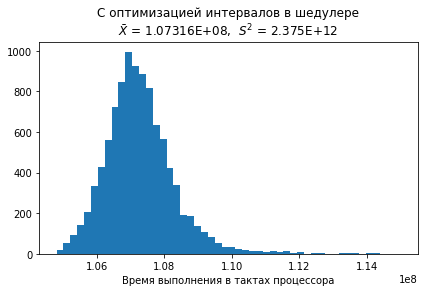

In [366]:
plot_and_save(elements_1, "C оптимизацией интервалов в шедулере", 'bench_sched_opt_10000.png', x_range)

In [315]:
elements_2 = calc_sample(N, "taskset 0x4", "cycles")

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



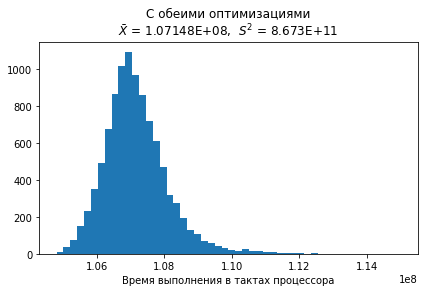

In [324]:
plot_and_save(elements_2, "C обеими оптимизациями", 'bench_all_opt_10000.png', x_range)

### kernel.sched_min_granularity_ns = 100000

In [317]:
!sudo /sbin/sysctl -w kernel.sched_min_granularity_ns='100000'

kernel.sched_min_granularity_ns = 100000


In [318]:
elements_3 = calc_sample(N, "taskset 0x1", "cycles")

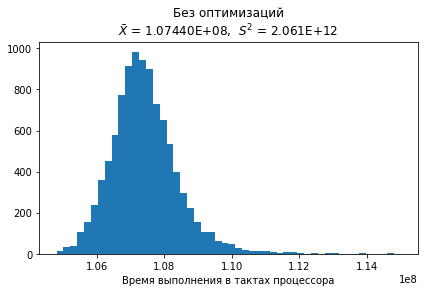

In [325]:
plot_and_save(elements_3, "Без оптимизаций", 'bench_no_opt_10000.png', x_range)

In [320]:
elements_4 = calc_sample(N, "taskset 0x4", "cycles")

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



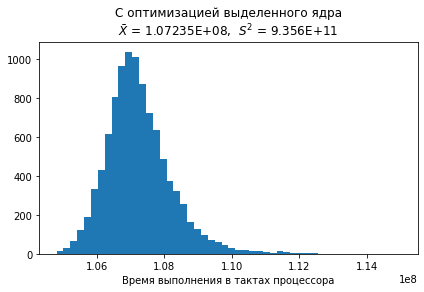

In [326]:
plot_and_save(elements_4, "C оптимизацией выделенного ядра", 'bench_separate_core_10000.png', x_range)

### kernel.sched_min_granularity_ns = 3000000

In [367]:
!sudo /sbin/sysctl -w kernel.sched_min_granularity_ns='3000000'

kernel.sched_min_granularity_ns = 3000000


In [368]:
elements_5 = calc_sample(N, "taskset 0x1", "cycles")

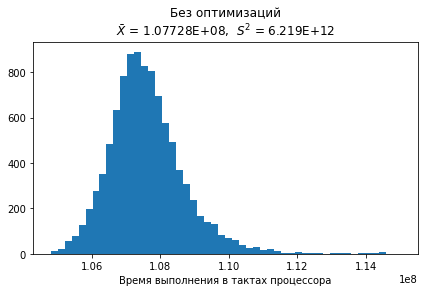

In [369]:
plot_and_save(elements_5, "Без оптимизаций", 'bench_no_opt_schdef_10000.png', x_range)

In [ ]:
elements_6 = calc_sample(N, "taskset 0x4", "cycles")

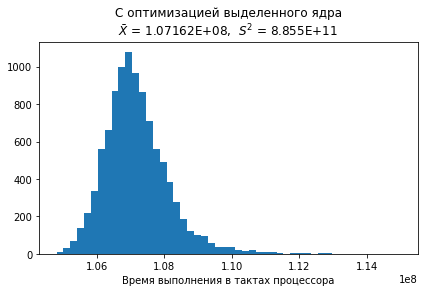

In [328]:
plot_and_save(elements_6, "C оптимизацией выделенного ядра", 'bench_separate_core_schdef_10000.png', x_range)

![df](./bench_all_opt.png)
![df](./bench_long_sched_opt.png)
![df](./bench_separate_core_10000.png)
![df](./bench_no_opt_10000.png)

Gamma
https://ru.wikipedia.org/wiki/%D0%93%D0%B0%D0%BC%D0%BC%D0%B0-%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5

$\mathbb {E} [X]=k{\theta }$

$\mathbb {D} [X]=k{\theta ^{2}}$

In [329]:
import numpy as np
from scipy.stats import gamma

shift = np.min(elements)
math_e = np.mean(elements) - shift

theta = np.var(elements) / math_e
k = math_e / theta
(shift, theta, k)

(104666842.0, 353220.69283527473, 7.166064331005756)

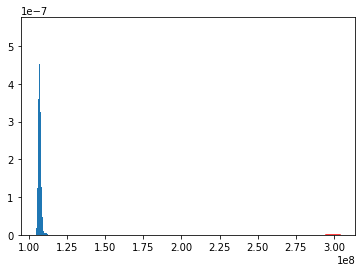

In [330]:
x = np.linspace(2.95e8, 3.04e8, 100)
plt.plot(x, gamma.pdf(x, a=k + 3.2, loc=shift, scale=theta / 1.8), 'r-', label='gamma pdf')

r = plt.hist(elements, bins=100, density=True)
plt.show()

In [209]:
r = np.histogram(elements, density=True, bins=100)

In [311]:
np.max(r[0] * np.diff(r[1]) - gamma.pdf(r[1][:-1], a=7.97, loc=2.97e8, scale=1.3e5))

0.06269887777928929

In [313]:
np.max(r[0] * np.diff(r[1]) - gamma.pdf(r[1][:-1], a=7.97, loc=290.99e8, scale=1.3e5))

0.06269999999999999

[3.54583605e-12 1.10642548e-10 9.77375326e-10 4.57360257e-09
 1.45803535e-08 3.59386445e-08 7.36594555e-08 1.31402645e-07
 2.10360057e-07 3.08765070e-07 4.22081928e-07 5.43724910e-07
 6.66061310e-07 7.81450729e-07 8.83130817e-07 9.65839869e-07
 1.02614289e-06 1.06248531e-06 1.07503310e-06 1.06537157e-06
 1.03613319e-06 9.90613133e-07 9.32415410e-07 8.65156136e-07
 7.92236393e-07 7.16686015e-07 6.41072230e-07 5.67462677e-07
 4.97430531e-07 4.32089509e-07 3.72147726e-07 3.17971240e-07
 2.69650176e-07 2.27062341e-07 1.89931001e-07 1.57874948e-07
 1.30450134e-07 1.07182899e-07 8.75954295e-08 7.12243190e-08
 5.76333087e-08 4.64212689e-08 3.72264430e-08 2.97278643e-08
 2.36447273e-08 1.87343609e-08 1.47893184e-08 1.16339839e-08
 9.12099145e-09 7.12766813e-09 5.55264396e-09 4.31271789e-09
 3.34002823e-09 2.57954655e-09 1.98689313e-09 1.52645841e-09
 1.16980647e-09 8.94332177e-10 6.82142044e-10 5.19129217e-10
 3.94214631e-10 2.98728731e-10 2.25910893e-10 1.70506466e-10
 1.28444155e-10 9.657901

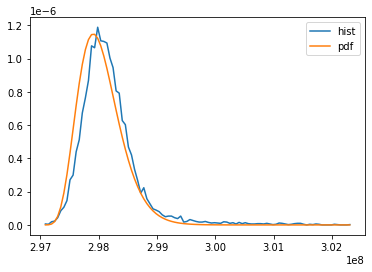

In [382]:
x = r[1][:-1]
plt.plot(x, r[0], label="hist")
plt.plot(x, gamma.pdf(r[1][:-1], a=7.97, loc=2.97e8, scale=1.3e5), label="pdf")

print(gamma.pdf(r[1][:-1], a=8.98, loc=2.97e8, scale=1.3e5))
plt.legend()
plt.show()

In [383]:
def gamma_loss(arg):
    k, shift, theta = arg
    shift *= 1e8
    theta *= 1e5
    distr = gamma.pdf(r[1][:-1] + np.diff(r[1]) / 2, a=k, loc=shift, scale=theta)
    delta = r[0] - distr
    return np.abs(delta).sum() * 1e7
    return (delta ** 2).sum() * 1e15

In [384]:
gamma_loss((7.97, 2.97e8, 1.3e5))

57.18200982747694

In [385]:
gamma_loss((7.97, 3.97e8, 1.3e5))

189.54302503465414

         Current function value: 17.934955
         Iterations: 1
         Function evaluations: 532
         Gradient evaluations: 104


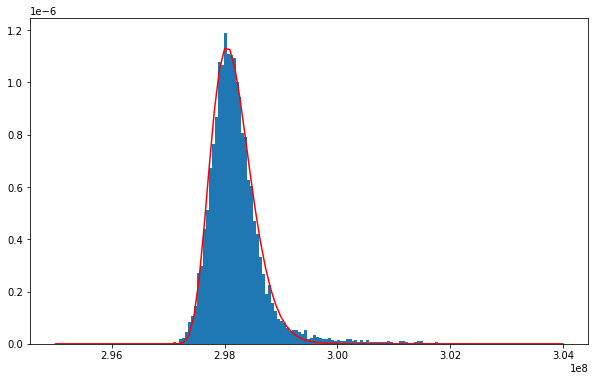

      fun: 17.93495514672416
 hess_inv: array([[ 5.56754265e-05,  0.00000000e+00, -3.02460095e-04],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-3.02460095e-04,  0.00000000e+00,  9.99999958e-01]])
      jac: array([ 0.11347246,  0.        , -0.00020719])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 532
      nit: 1
     njev: 104
   status: 2
  success: False
        x: array([9.9749458e+00, 2.9700000e+08, 1.1600000e+05])

In [407]:
from scipy.optimize import minimize

res = minimize(gamma_loss, (9.975, 2.97e8, 1.16e5), 
         #bounds=[(5, 10), (2.95e8, 2.98e8), (0.5e5, 3e5)],
         method='BFGS',
         options={'disp': True, 'maxiter': 1000})

# res = minimize(lambda x: gamma_loss((8.98, x[0], x[1])), (2.97e8, 1.3e5), 
#           #bounds=[(2.95e8, 2.98e8), (0.5e5, 3e5)],
#           method='BFGS',
#           options={'disp': True, 'maxiter': 1000})
# res.x = (8.98, res.x[0], res.x[1])


plt.figure(figsize=(10, 6))
x = np.linspace(2.95e8, 3.04e8, 100)
plt.plot(x, gamma.pdf(x, a=res.x[0], loc=res.x[1], scale=res.x[2]), 'r-', label='gamma pdf')
r = plt.hist(elements, bins=100, density=True)
plt.show()

res

In [392]:
np.diff(r[1])

array([52758.47000003, 52758.46999997, 52758.47000003, 52758.46999997,
       52758.47000003, 52758.46999997, 52758.47000003, 52758.46999997,
       52758.47000003, 52758.46999997, 52758.47000003, 52758.46999997,
       52758.47000003, 52758.46999997, 52758.47000003, 52758.46999997,
       52758.47000003, 52758.46999997, 52758.47000003, 52758.46999997,
       52758.47000003, 52758.46999997, 52758.47000003, 52758.46999997,
       52758.47000003, 52758.47000003, 52758.46999997, 52758.47000003,
       52758.46999997, 52758.47000003, 52758.46999997, 52758.47000003,
       52758.46999997, 52758.47000003, 52758.46999997, 52758.47000003,
       52758.46999997, 52758.47000003, 52758.46999997, 52758.47000003,
       52758.46999997, 52758.47000003, 52758.46999997, 52758.47000003,
       52758.46999997, 52758.47000003, 52758.46999997, 52758.47000003,
       52758.46999997, 52758.47000003, 52758.47000003, 52758.46999997,
       52758.47000003, 52758.46999997, 52758.47000003, 52758.46999997,
      

In [34]:
def gen_function_template_params_sample(params_count, use_count):
    params = [f"T{i}" for i in range(params_count)]
    def random_type(i, argn):
        if argn < 60:
            return "int" if (i >> argn) & 1 else "char"
        return "int" if random.random() < 0.5 else "char"
    types_list = ",".join(f'typename {t}' for t in params)
    decl_args_list = ",".join(f'{t} var{t}' for t in params)
    template_args_lists = [
        ", ".join(random_type(i, ti) for ti in range(params_count))
        for i in range(use_count)
    ]
    args_list = ", ".join("0" for t in params)
    code = f'''
    template <{types_list}>
    void function({decl_args_list}) {{}};
    
    int var_1 = (
    ''' + ",".join(
        f"function<{template_arg_list}>({args_list})"
        for i, template_arg_list in enumerate(template_args_lists)
    ) + '''
    , 0);
    '''
    return code.replace(' ' * 4, '')

print(gen_function_template_params_sample(2, 2))


template <typename T0,typename T1>
void function(T0 varT0,T1 varT1) {};

int var_1 = (
function<char, char>(0, 0),function<int, char>(0, 0)
, 0);



In [39]:
check_code(gen_function_template_params_sample(2, 2))

In [357]:

normed_elements = np.array(elements)
normed_elements /= normed_elements.mean()

def check_metric(metric_f):
    vals = [metric_f(np.random.choice(normed_elements, 100)) for i in range(100000)]
    return np.var(vals)

print(check_metric(np.mean))
print(check_metric(lambda a: np.array(np.sort(a))[int(len(a) * 0.5)]))
print(check_metric(lambda a: np.array(np.sort(a))[0]))
print(check_metric(lambda a: np.array(np.sort(a))[:int(len(a) * 0.75)].mean()))

7.770414173252975e-07
9.906201464700064e-07
6.794129903990938e-06
6.048765641778306e-07


In [358]:
ks = np.arange(0.05, 1.01, 0.05)
k_metrics = [
    check_metric(lambda a: np.array(np.sort(a))[:int(len(a) * k)].mean()) 
    for k in tqdm(ks)
]

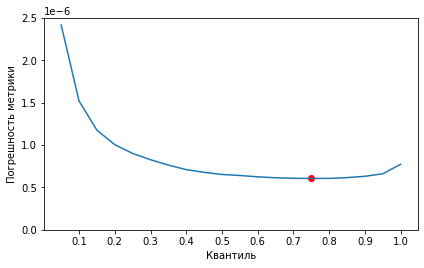

0.7843235841629607


In [362]:
plt.plot(ks, k_metrics)
plt.xticks(np.arange(0.0, 1.01, 0.1))
plt.ylim((0.0, 2.5e-6))
plt.yticks(np.arange(0.0, 2.51e-6, 0.5e-6))
b = 14
plt.scatter(ks[b], k_metrics[b], color='r')
plt.xlabel("Квантиль")
plt.ylabel("Погрешность метрики")
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.savefig("choosing_k_metric.png")
plt.show()

print(k_metrics[b] / k_metrics[-1])